# ISIC 2018 Lession Diagnosis Challenge
https://challenge2018.isic-archive.com


## Step 0: Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## Using Fast.ai library from Paperspace
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.set_device(0)
torch.backends.cudnn.enabled

True

Get data from https://challenge2018.isic-archive.com/task3/training/

In [4]:
PATH = "data/lessionChallenge/"
sz = 224
arch = resnext101_64
bs = 24

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [6]:
n

10015

In [7]:
len(val_idxs)

2003

In [8]:
# If you haven't downloaded weights.tgz yet, download the file.
#     http://forums.fast.ai/t/error-when-trying-to-use-resnext50/7555
#     http://forums.fast.ai/t/lesson-2-in-class-discussion/7452/222
#!wget -O fastai/weights.tgz http://files.fast.ai/models/weights.tgz

#!tar xvfz fastai/weights.tgz -C fastai

## Step 1: Initial exploration

In [9]:
!ls {PATH}

labels.csv  tmp  train


In [10]:
label_df = pd.read_csv(label_csv)

In [11]:
label_df.head()

,images,disease
0,ISIC_0024306,NV
1,ISIC_0024307,NV
2,ISIC_0024308,NV
3,ISIC_0024309,NV
4,ISIC_0024310,MEL


In [12]:
label_df.pivot_table(index="disease", aggfunc=len).sort_values('images', ascending=False)

,images
disease,
NV,6705
MEL,1113
BKL,1099
BCC,514
AKIEC,327
VASC,142
DF,115


In [13]:
#We have unbalanced classes 
#to-do

In [14]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv',
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [15]:
fn = PATH + data.trn_ds.fnames[0]; fn

'data/lessionChallenge/train/ISIC_0024307.jpg'

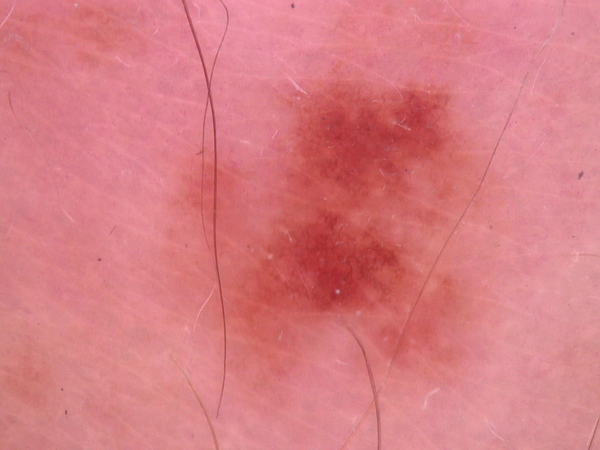

In [16]:
img = PIL.Image.open(fn); img

In [17]:
img.size

(600, 450)

In [18]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [19]:
row_sz, col_sz = list(zip(*size_d.values()))

In [20]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [21]:
row_sz[:5]

array([600, 600, 600, 600, 600])

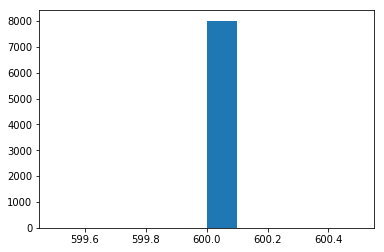

In [22]:
plt.hist(row_sz);

(array([   0.,    0.,    0.,    0.,    0., 8012.,    0.,    0.,    0.,    0.]),
 array([599.5, 599.6, 599.7, 599.8, 599.9, 600. , 600.1, 600.2, 600.3, 600.4, 600.5]),
 <a list of 10 Patch objects>)

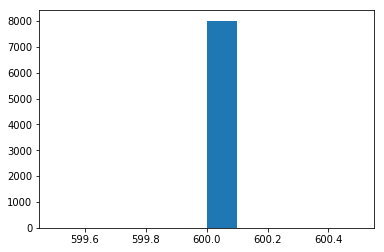

In [23]:
plt.hist(row_sz[row_sz < 1000])

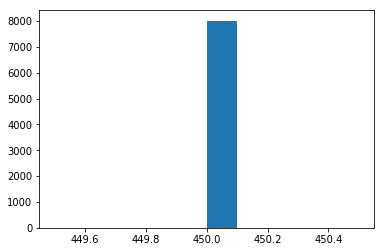

In [24]:
plt.hist(col_sz);

(array([   0.,    0.,    0.,    0.,    0., 8012.,    0.,    0.,    0.,    0.]),
 array([449.5, 449.6, 449.7, 449.8, 449.9, 450. , 450.1, 450.2, 450.3, 450.4, 450.5]),
 <a list of 10 Patch objects>)

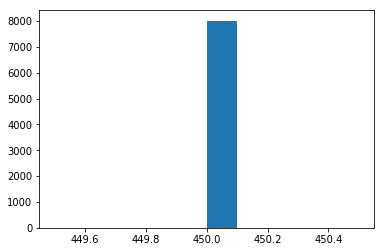

In [25]:
plt.hist(col_sz[col_sz < 1000])

In [26]:
len(data.classes), data.classes[:5]

(7, ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL'])

## Step 2: Initial model

In [27]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

### Precompute

In [28]:
data = get_data(sz, bs)

In [29]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [30]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [51]:
learn.fit(2e-2, 3)

epoch      trn_loss   val_loss   accuracy                     
    0      0.934163   0.750148   0.729905  
    1      0.742284   0.73686    0.735397                     
    2      0.678888   0.634324   0.771343                     



[array([0.63432]), 0.7713429840040754]

## Step 3: Evaluation Metric

In [33]:
from sklearn.metrics import confusion_matrix


def get_balanced_accuracy(probs,y,classes): # sz: image size, bs: batch size
    preds = np.argmax(probs, axis=1)
    probs = probs[:,1]
    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, classes)
    return ((
    cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2]+cm[0][3]+cm[0][4]+cm[0][5]+cm[0][6]) + 
    cm[1][1]/(cm[1][0]+cm[1][1]+cm[1][2]+cm[1][3]+cm[1][4]+cm[1][5]+cm[1][6]) +
    cm[2][2]/(cm[2][0]+cm[2][1]+cm[2][2]+cm[2][3]+cm[2][4]+cm[2][5]+cm[2][6]) +
    cm[3][3]/(cm[3][0]+cm[3][1]+cm[3][2]+cm[3][3]+cm[3][4]+cm[3][5]+cm[3][6]) +
    cm[4][4]/(cm[4][0]+cm[4][1]+cm[4][2]+cm[4][3]+cm[4][4]+cm[4][5]+cm[4][6]) +
    cm[5][5]/(cm[5][0]+cm[5][1]+cm[5][2]+cm[5][3]+cm[5][4]+cm[5][5]+cm[5][6]) +
    cm[6][6]/(cm[6][0]+cm[6][1]+cm[6][2]+cm[6][3]+cm[6][4]+cm[6][5]+cm[6][6]) 
    )/7)
    

[[  24    6   22    0    3    7    0]        
 [  14   53   17    0    2   20    0]
 [  10    9  121    1    8   57    0]
 [   0    0    3    2    2   15    0]
 [  12    7   33    0   62  125    0]
 [   5   11   38    0   14 1268    2]
 [   0    3    2    0    0    5   20]]


0.49130692965793055

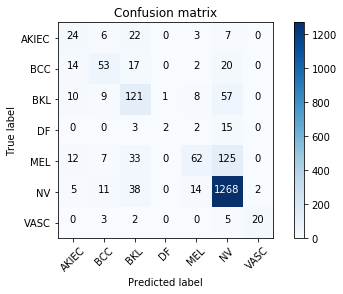

In [52]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
get_balanced_accuracy(probs,y,data.classes)

## Step 4: Find Learning Rate

In [53]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [54]:
lrf=learn.lr_find()

 78%|███████▊  | 259/334 [00:02<00:00, 102.77it/s, loss=2.42]


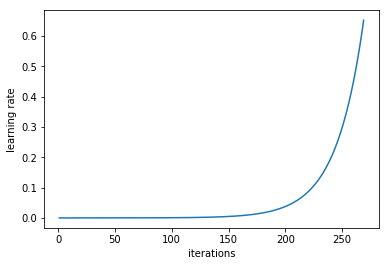

In [55]:
learn.sched.plot_lr()

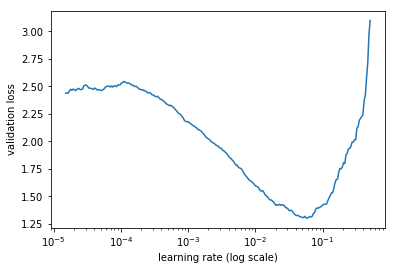

In [56]:
learn.sched.plot()

The loss is still clearly improving at lr=(1e-2), so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

## Step 5: Augment

In [57]:
from sklearn import metrics

In [58]:
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy                     
    0      0.797388   0.682876   0.756865  



[array([0.68288]), 0.7568647007435129]

In [59]:
learn.precompute = False

In [60]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.659925   0.607934   0.781827  
    1      0.685723   0.58764    0.791313                    
    2      0.679308   0.585826   0.796306                    



[array([0.58583]), 0.7963055399317653]

In [41]:
learn.save('resnet101_224_pre')

In [42]:
learn.load('resnet101_224_pre')

## Step 6: Fine-tuning and differential learning rate annealing

In [63]:
learn.unfreeze()
lr=np.array([1e-2/9,1e-2/3,1e-2])

In [64]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.60518    0.501923   0.820769  
    1      0.562696   0.45255    0.832751                    
    2      0.345464   0.41636    0.849725                    
    3      0.431078   0.499346   0.834748                    
    4      0.312239   0.40241    0.870694                    
    5      0.18422    0.382858   0.883175                    
    6      0.120802   0.385176   0.877184                    



[array([0.38518]), 0.8771842254797221]

In [45]:
learn.save('resnext101_224_all')

In [46]:
learn.load('resnext101_224_all')

[[  43    5    3    1    7    3    0]        
 [   5   90    5    0    1    5    0]
 [   4    5  154    0   16   27    0]
 [   1    2    1   16    0    2    0]
 [   2    1   12    0  182   42    0]
 [   2    8   20    4   44 1258    2]
 [   0    1    0    0    0    0   29]]


0.8122618205796984

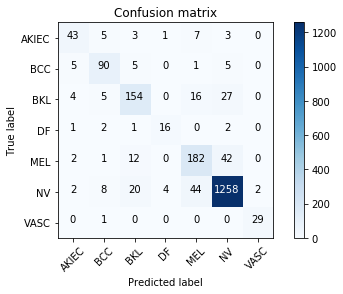

In [67]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
get_balanced_accuracy(probs,y,data.classes)

In [10]:
#learn.load('final_challenge1')

## Step 7: Increase Size

In [68]:
bs=12
learn.set_data(get_data(299, bs)) 
learn.freeze()

In [69]:
learn.fit(1e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.165145   0.351372   0.884174  
    1      0.139399   0.353684   0.886171                    
    2      0.146376   0.351027   0.88667                     



[array([0.35103]), 0.8866699970607691]

[[  43    3    4    1    7    4    0]        
 [   5   87    5    0    2    7    0]
 [   6    5  159    0   11   25    0]
 [   3    2    2   12    0    3    0]
 [   3    1   11    0  166   58    0]
 [   2    6   16    0   30 1283    1]
 [   0    1    0    0    0    1   28]]


0.7740557405665646

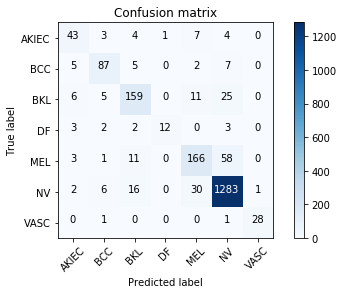

In [70]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
get_balanced_accuracy(probs,y,data.classes)

In [ ]:
learn.unfreeze()
lr=np.array([1e-2/9,1e-2/3,1e-2])

In [21]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.503443   0.46489    0.831752  
    1      0.586124   0.589942   0.79331                     
    2      0.406127   0.414243   0.856216                    
    3      0.661858   0.724284   0.762856                    
    4      0.505099   0.457036   0.832751                    
    5      0.389157   0.404119   0.858213                    
    6      0.307188   0.377318   0.871692                    



[array([0.37732]), 0.8716924626471338]

In [22]:
learn.save('resnet101_299_unfrozen')

In [23]:
learn.load('resnet101_299_unfrozen')